In [80]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [81]:
import matplotlib.colors as colors
import matplotlib.animation as animation
import matplotlib.ticker as mtick
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
plt.rcParams['animation.ffmpeg_path'] = r'C:\ffmpeg\bin\ffmpeg.exe'

In [82]:
import numpy as np
import scipy.special as spec
import scipy.integrate as inte
import sympy as sp
sp.init_printing()

# Position du problème

Étant donné un fil électrique très long parcouru par un courant électrique $i$, on cherche à déterminer le champ magnétique créé par phénomène d'induction dans l'espace autour. On peut le détecter en approchant une boussole, de la limaille de fer ou d'autres aimants permanents du fil, voire approcher un autre fil électrique lui aussi parcouru par un courant.

# Construction du champ magnétique

Les cellules suivantes servent à construire la fonction $B$ correspondant à l'intensité du champ magnétique $\mathbf{B}$ à une distance $r$ du fil, à l'instant $t$.

In [83]:
r, omega = sp.symbols('r omega', positive = True) # Distance et fréquence
t, phi = sp.symbols('t phi', real=True) # Temps et phase
Ic = sp.symbols('I') # Courant électrique

mu = sp.symbols("mu0", positive = True) # Perméabilité magnétique du vide
c = sp.symbols("c", positive=True)      # Célérité de la lumière dans le vide
k = omega/c                             # relation de dispersion

# Composante du potentiel vecteur associée à la pulsation omega
A_component = -mu*Ic/4* \
    (sp.bessely(0,k*r) + sp.I*sp.besselj(0,k*r))*sp.exp(sp.I*(omega*t-phi))

# Composante du champ associée à la pulsation omega
B_component = -A_component.diff(r).simplify()
B_comp_real = sp.re(B_component)

# Création du champ (symbolique et fonction) en sommant les composantes
def create_Bfield(intens,puls,phas):
    # Constantes numériques à substituer
    spectr = zip(intens,puls,phas)
    c0 = 3e8
    mu0_v = 4e-7*np.pi
    
    B_field = sum([B_comp_real.subs({Ic: cur, omega:om, phi:ph, c:c0, mu:mu0_v}) \
            for (cur,om,ph) in spectr if (cur!=0 and om!=0)])
    
    B_function = sp.lambdify((r, t), B_field, 
        modules=['numpy',{"besselj":spec.jn, "bessely":spec.yn}])
    
    return B_field, B_function

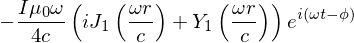

In [84]:
B_component

In [196]:
def graphe_B(times, ani = False, custTitl = None):
    '''
    Construit les graphes du champ magnétique B aux temps donnés dans la liste
    "times"
    Si le drapeau 'ani' est True, alors entrer en mode "animation"
    '''
    radii = np.linspace(rmin, rmax, 1000)
    
    fig = plt.figure(1, figsize=(8,5))
    ax = plt.axes()
    ax.set_xlim((0,rmax))
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
    
    # Donne la légende 'temps'
    def legende(ti):
        out = r'$t= {:.3e}$'.format(ti)
        out = out + r"$\ \mathrm{s}$"
        return out
        
    if not(ani):
        if hasattr(times, '__iter__'):
            for ti in times:
                champ = B_function(radii, ti)
                ax.plot(radii, champ, label=legende(ti))
        else:
            champ = B_function(radii, times)
            ax.plot(radii, champ, label=legende(times))
        ax.legend(loc='best')
    else:
        line, = ax.plot([], [], lw=2)
        time_text = ax.text(0.02, 0.95, '', 
                            transform=ax.transAxes)
        
        
        t0, t1= times
        interval = t1 - t0
        animtime = 15
        fps = 30
        dt = interval/animtime # secondes vidéo par seconde réelle
        framenum = int(np.ceil(fps*animtime))
        
        ymax = B_function(radii,t0).max()
        
        ax.set_ylim((-ymax,ymax))
        
        def init():
            line.set_data([],[])
            time_text.set_text('')
            return line, time_text
        
        def animate(i):
            ti = dt*i/fps+t0
            legende_temps = legende(ti)
            champ = B_function(radii, ti)
            line.set_data(radii, champ)
            time_text.set_text(legende_temps)
            return line, time_text
        
    ax.grid(True)
    ax.set_xlabel("Distance $r$ (m)")
    ax.set_ylabel("Valeur du champ (T)")
    if custTitl:
        ax.set_title(custTitl)
    else:
        ax.set_title(r'Champ magnétique ' + r'$\mathbf{B}$' \
                     + ' créé par un courant variable')

    
    fig.tight_layout()
    
    if ani:
        anima = animation.FuncAnimation(fig, animate, init_func=init,
                    frames = framenum, interval = interval, blit = True)
        mywriter = animation.FFMpegWriter(fps=fps, bitrate=1000)
        anima.save('champ_mag_anim.mp4', writer=mywriter)
        fig.tight_layout()
    else:
        return fig, ax



In [86]:
def build_field(t, colmap='bone'):
    """
    Portrait du champ magnétique à l'instant t
    """
    wind = rmax
    
    def field_func(x,y):
        r = np.sqrt(x*x+y*y)
        Btheta = B_function(r, t)
        direct = np.array([-y/r, x/r])
        return Btheta*direct
    
    Y, X = np.ogrid[-wind:wind:1000j, -wind:wind:1000j]
    BX, BY = field_func(X, Y)
    intensity = np.sqrt(BX**2+BY**2)
    
    
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
   
    heat = ax.imshow(intensity, 
                     cmap=colmap,
                     norm=colors.LogNorm(), 
                     extent=[-wind, wind, -wind, wind], 
                     alpha=0.6)
    cbar = fig.colorbar(heat,
                label='Intensité du champ (T)')
    
    strm = ax.streamplot(X,Y, BX, BY, 
        arrowstyle='->', 
        color='w',
        linewidth=0.8,
        arrowsize=2,
        density=1.4,
        )
    
    ax.grid(False)
    ax.set_aspect('equal')
    ax.set_xlim((-wind,wind))
    ax.set_ylim((-wind,wind))
    title_text = r'Champ magnétique $\mathbf{B}$ à '
    title_text += r"$t={:g}$".format(t)
    title_text += r" $\mathrm{s}$"
    ax.set_title(title_text)
    fig.tight_layout()
    
    return fig
    

# Tracés

## Données initiales

Entrez dans la variable `freqs` les fréquences du courant voulu, et dans `phas` les phases associées, et exécutez la cellule (`Ctrl + Entrée` sur le clavier) pour définir la fonction de champ :

In [91]:
freqs = np.array([n*1e8 for n in range(5,7)] + \
    [n*1e5 for n in range(2,5)])

puls = 2*np.pi*np.asarray(freqs) # Pulsations associées
intens = np.array([2,3,1,4,1]) # Intensités des composantes

phases = np.array([0,0,0,0,0]) # Phases des composantes

B_field, B_function = create_Bfield(intens, puls, phases)

La cellule suivante définit les distances minimale et maximale pour lesquels tracer le profil du champ magnétique :

In [92]:
rmin = 0.03
rmax = 2

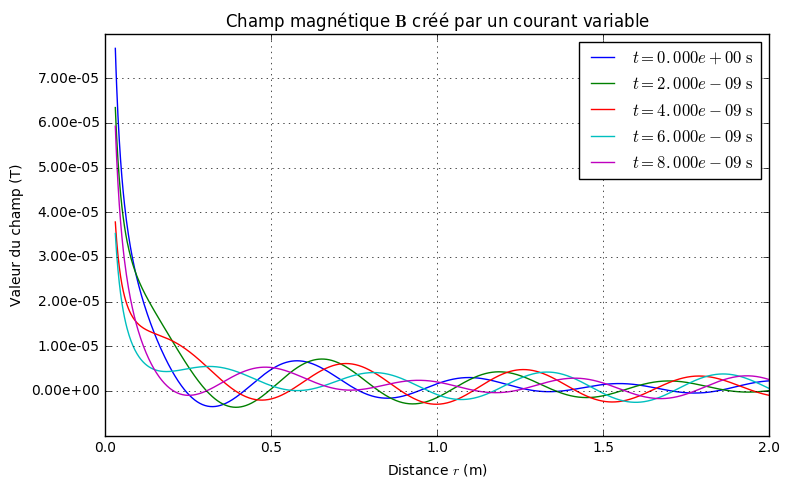

In [93]:
times = [1e-9*k for k in [0, 2, 4, 6, 8]]

profil_B = graphe_B(times)
profil_B[0].savefig("profil_champmag.pdf")
profil_B[0].savefig("profil_champmag.png")

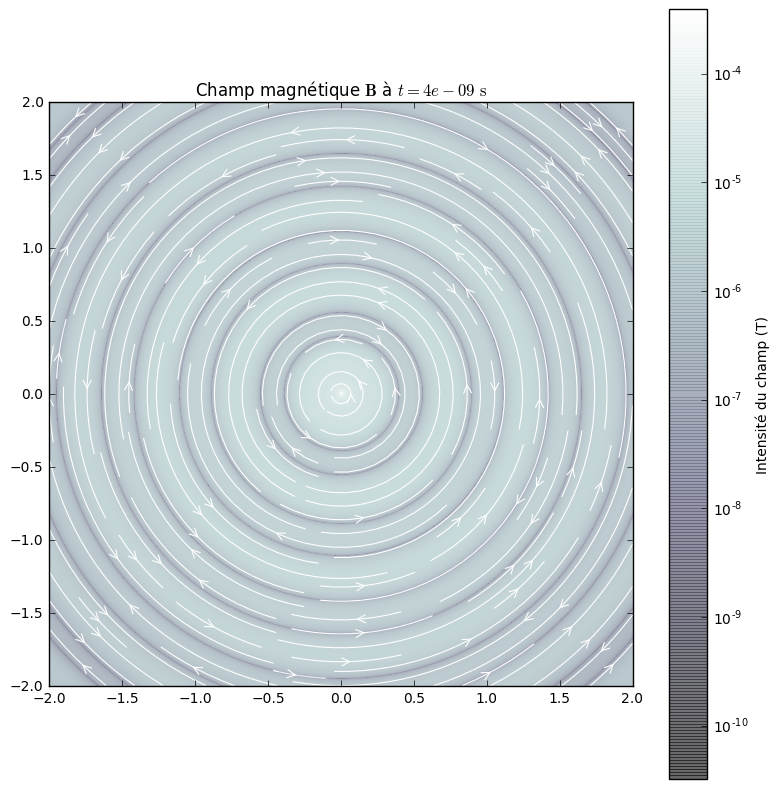

In [11]:
t = times[2]    # Temps auquel calculer le portrait du champ (pas de liste)

field_lines = build_field(t)
field_lines.savefig('portrait_champmag.pdf')
field_lines.savefig('portrait_champmag.png')

## Animations

Modifiez cette cellule avec les fréquences que vous voulez utiliser pour les animations :

In [ ]:
freqs = [n*1e8 for n in range(5,7)] + \
    [n*1e7 for n in range(2,5)]

puls = 2*np.pi*np.array(freqs) # Pulsations associées

intens = [1,5,1,2,5] # Intensités des composantes
phases = [0,0,0,0,0] # Phases des composantes

B_field, B_function = create_Bfield(intens, puls, phases)

In [ ]:
rmin = 0.03
rmax = 2

In [ ]:
times_an = [0, 1e-8]

graphe_B(times_an, True)

## Paquet d'ondes gaussien

In [182]:
def gaussienne(tau,t):
    tard = t - 0
    return np.exp(-tard**2/(2*tau**2))

def draw_gaussienne(tau):
    T = np.linspace(-N/fs, N/fs, N+1)
    Y = gaussienne(tau, T)
    fig, ax = plt.subplots(1,1,figsize=(8,5))
    ax.grid(True)
    ax.plot(T, Y)
    ax.set_xlabel(r"Temps $t$ (s)")
    title = r"Paquet d'onde d'extension $\tau = {:.1e}$ ".format(tau) + r"$\mathrm{s}$"
    fig.suptitle(title)

In [183]:
tau = 1e-10
N = 2**7 # Nombre d'échantillons
fs = 2**35 # Fréquence d'échantillonnage

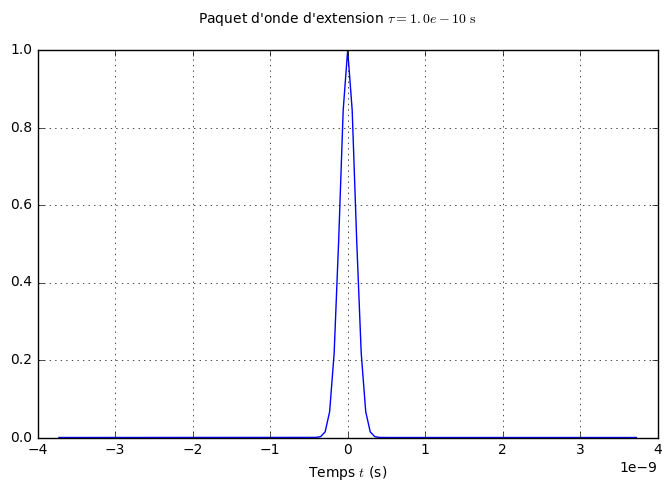

In [185]:
draw_gaussienne(tau)

In [187]:
def fft_gauss(tau, N):
    """
    N: nombre d'échantillons
    """
    dt = 1/fs # Pas
    
    sampled_time = np.linspace(-N*dt,N*dt,N+1)
    courant = gaussienne(tau, sampled_time)/np.sqrt(2*np.pi*tau)
    return courant

In [189]:
courant = fft_gauss(tau, N)

intens = np.fft.rfft(courant) # Intensités
puls = np.fft.rfftfreq(N, d=1/fs)     # Pulsations associées

phases = np.zeros(N//2+1) # Phases des composantes

In [195]:
spector = np.dstack((puls,np.abs(intens),np.angle(intens))) # Éléments du spectre
print(spector)

[[[  0.00000000e+00   1.71798692e+05   0.00000000e+00]
  [  2.68435456e+08   1.71198279e+05  -3.11723922e+00]
  [  5.36870912e+08   1.69409602e+05   4.87068628e-02]
  [  8.05306368e+08   1.66469906e+05  -3.06853236e+00]
  [  1.07374182e+09   1.62439831e+05   9.74137257e-02]
  [  1.34217728e+09   1.57401335e+05  -3.01982550e+00]
  [  1.61061274e+09   1.51454917e+05   1.46120589e-01]
  [  1.87904819e+09   1.44716292e+05  -2.97111863e+00]
  [  2.14748365e+09   1.37312654e+05   1.94827451e-01]
  [  2.41591910e+09   1.29378699e+05  -2.92241177e+00]
  [  2.68435456e+09   1.21052590e+05   2.43534314e-01]
  [  2.95279002e+09   1.12472014e+05  -2.87370491e+00]
  [  3.22122547e+09   1.03770509e+05   2.92241177e-01]
  [  3.48966093e+09   9.50741616e+04  -2.82499805e+00]
  [  3.75809638e+09   8.64988129e+04   3.40948040e-01]
  [  4.02653184e+09   7.81478212e+04  -2.77629118e+00]
  [  4.29496730e+09   7.01104390e+04   3.89654903e-01]
  [  4.56340275e+09   6.24608058e+04  -2.72758432e+00]
  [  4.831

In [191]:
def draw_fft_gauss():
    fig, (ax0,ax1) = plt.subplots(2,1,figsize=(8,7), dpi=100)
    ax0.grid(True)
    ax1.grid(True)
    ax0.plot(puls, np.abs(intens) )
    ax1.plot(puls, np.angle(intens), 'g' )
    title = "Spectre en fréquence d'un paquet " \
            + r"d'ondes d'extension $\tau={:.1e}$ ".format(tau) \
            + r"$\mathrm{s}$"
    fig.suptitle(title)

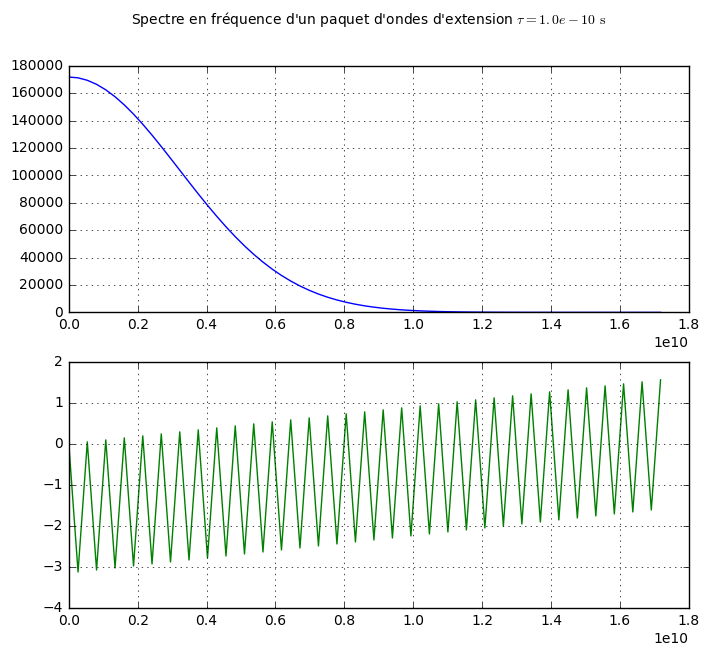

In [192]:
draw_fft_gauss()

In [179]:
B_field, B_function = create_Bfield(intens, puls, phases)

In [101]:
rmin = 0.5
rmax = 20

(<matplotlib.figure.Figure at 0xb4351d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0xd616f98>)

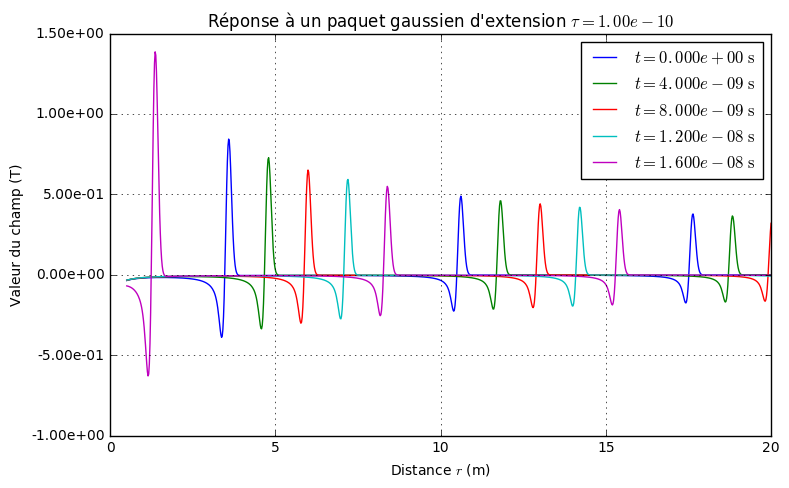

In [198]:
times = [1e-9*4*k for k in range(5)]
titre_gauss = r"Réponse à un paquet gaussien d'extension $\tau={:.2e}$".format(tau)
graphe_B(times, custTitl=titre_gauss)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "K:\Bureau\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-103-0867e1d6c006>", line 3, in <module>
    graphe_B(times, True)
  File "<ipython-input-85-ff7e0081e507>", line 69, in graphe_B
    anima.save('champ_mag_anim.mp4', writer=mywriter)
  File "K:\Bureau\anaconda3\lib\site-packages\matplotlib\animation.py", line 829, in save
    with writer.saving(self._fig, filename, dpi):
  File "K:\Bureau\anaconda3\lib\contextlib.py", line 59, in __enter__
    return next(self.gen)
  File "K:\Bureau\anaconda3\lib\site-packages\matplotlib\animation.py", line 200, in saving
    self.setup(*args)
  File "K:\Bureau\anaconda3\lib\site-packages\matplotlib\animation.py", line 190, in setup
    self._run()
  File "K:\Bureau\anaconda3\lib\site-packages\matplotlib\animation.py", line 218, in _run
    creationflags=subprocess_creation_flags)
  File "K

FileNotFoundError: [WinError 2] Le fichier spécifié est introuvable

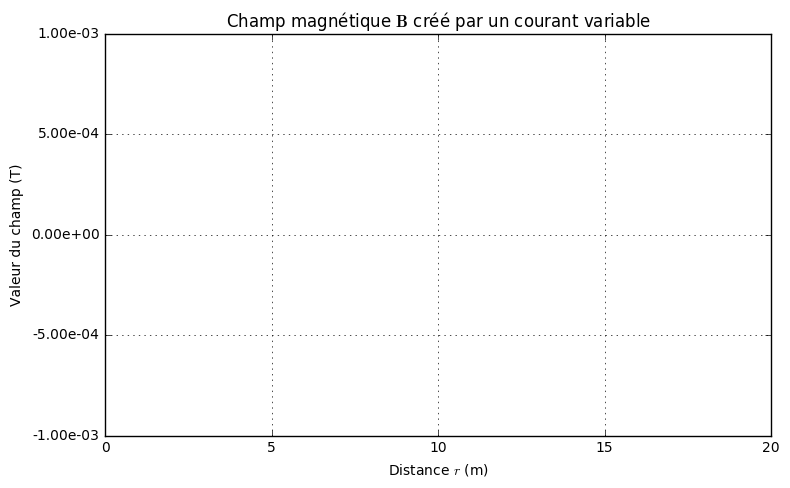

In [103]:
times = [0,1e-9]

graphe_B(times, True)

# Théorie (Bac + 1,5)

Le champ magnétique $\mathbf{B}$ dérive d'un champ $\mathbf A$ appelé *potentiel vecteur* : $\mathbf{B} = \boldsymbol\nabla\wedge\mathbf{A}$. Par symétrie cylindrique, on a $\mathbf{B}(\mathbf r, t) = B(r,t)\mathbf{e}_\theta$. Par suite $\mathbf A(\mathbf r,t) = A(r,t)\mathbf e_z$.

Le potentiel vecteur $\mathbf{A} = A(r,t)\mathbf{e}_z$ est solution de l'équation d'onde

\begin{equation}
\Delta\mathbf A  - \frac{1}{c^2}\frac{\partial^2\mathbf A}{\partial t^2} = - \mu_0\mathbf{J}(r,t),
\end{equation}

avec $\mathbf J(r,t)  = \dfrac{i(t)\delta(r)}{2\pi r}\mathbf{e}_z$ la densité volumique de courant.


Pour un courant sinusoïdal $i(t) = I\exp(i\omega t)$, le potentiel s'écrit $A(r,t) = f(r)\exp(i\omega t)$ et l'équation aux dérivées partielles se réduit à

\begin{equation}
\frac{1}{r}\frac{\mathrm d}{\mathrm dr}\left(r\frac{\mathrm df}{\mathrm dr} \right) + k^2f(r) = -\frac{\mu_0I\delta(r)}{2\pi r},
\end{equation}

avec $k=\dfrac{\omega}{c}$.

La solution générale prend la forme

$$
f(r) = CJ_0(kr) + DY_0(kr)
$$

où $C$ et $D$ dépendent de la pulsation $\omega$ du courant, et $J_0,Y_0$ sont les 0-ièmes fonctions de Bessel de la première et seconde espèce, solutions de $$xy''(x) + y'(x) + xy(x) = 0.$$